### imports

In [1]:
import numpy as np   # basic numeric module in python, for array and matrix computation
import pandas as pd  # advanced numeric module, excels in data frame analysis
import os
import scipy.stats as stats
import matplotlib.pyplot as plt  # for data visualization
%pylab inline
from mpl_toolkits.mplot3d import Axes3D  # for 3D plot
import statsmodels.formula.api as smf    # for OLS regression
#import matplotlib.mlab as mlab
import math
from scipy.stats import norm
#from scipy import stats, integrate
#import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


### make sure PUI2016 exists

In [2]:
if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
print (os.getenv ('PUI2016'))
print (os.getenv ('PUIDATA'))

/home/cusp/rav220/PUI2016
/home/cusp/rav220/PUIdata


### function to download file

In [3]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    # check if not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file...")
        # otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            # unzip 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
                os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    # one final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("The file is not there...")

    else:
        print ("File is in place...")
        
print('ok?')

ok?


### download file

In [ ]:
datestring = '201402'
getCitiBikeCSV(datestring)

### read file to dataframe

In [5]:
dataf = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
len(dataf)

224736

In [6]:
dataf.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

### remove unecessary info

In [7]:
# Remove uncessary info

dataf.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype'], axis = 1, inplace = True)

dataf = dataf[dataf['gender'] > 0]
dataf.columns

Index([u'birth year', u'gender'], dtype='object')

### replace dataframe to convert items to integers (had problems otherwise)

In [8]:
# convert datframe items to integers (consistently ran into trouble here, but finally resolved)

the_list = list(dataf['birth year'])

for x in range(0,len(dataf)):
    the_list[x] = 2016-float(the_list[x])
    
df = pd.DataFrame(the_list, columns=["age"])

df.columns

Index([u'age'], dtype='object')

In [9]:
df.head(3)

,age
0,25.0
1,37.0
2,68.0


### plot and test normal distribution

Gaussian KS Statistic: 0.0999940330074
Gaussian KS PValue: 0.0

Gaussian AD: AndersonResult(statistic=2793.4941205939976, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))


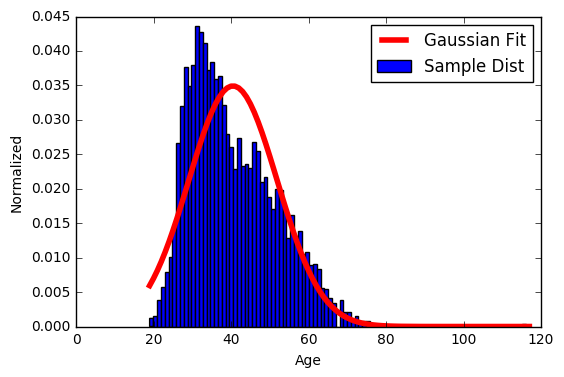

In [10]:
#df = df.dropna

ssort = sorted(df.age)
u = np.mean(ssort)
sd = np.std(ssort)
vr = np.var(ssort)
fit = stats.norm.pdf(ssort, u,sd)


plt.hist(ssort,100,normed=1, label="Sample Dist")

plt.plot(ssort, fit, linewidth = 4, color = "red", label = 'Gaussian Fit')
plt.ylabel('Normalized')
plt.xlabel('Age')
plt.legend()

ks_stat_gaussian, ks_pvalue_gaussian = stats.kstest(ssort,'norm',args=(u,sd))
AD_gaussian = stats.anderson(ssort, dist='norm')
print "Gaussian KS Statistic:", ks_stat_gaussian
print "Gaussian KS PValue:", ks_pvalue_gaussian
print ""
print "Gaussian AD:", AD_gaussian

## N0:  Sample Distribution is not different from Normal Distribution (alpha >.05)
## N0 is rejected:  P < 0.05 in under both tests (KS & AD)

### plot and test Poisson dist:

Two-Tail Poisson Distribution KS Statistic: 0.20036696406
Two-Tail Poisson Distribution KS P-Value: 0.0
One-Tail Poisson Distribution KS Statistic: 0.561856857637
One-Tail Poisson Distribution KS P-Value: 0.0


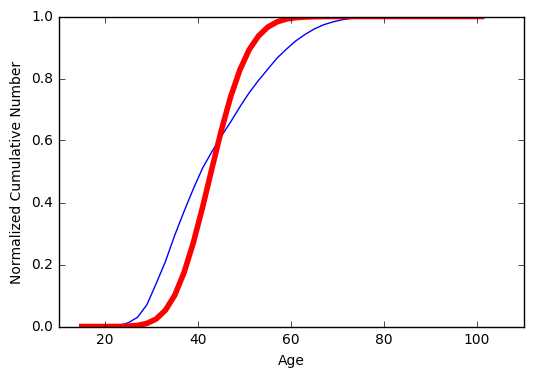

In [11]:
bins = np.arange(10, 99, 2)

cs=df.age.groupby(pd.cut(df.age, bins)).agg([count_nonzero]).cumsum()

rp = np.random.poisson(u,len(ssort))
rpdf =pd.DataFrame(rp)
rpdf.columns = ['ph']

csp=rpdf.ph.groupby(pd.cut(rpdf.ph, bins)).agg([count_nonzero]).cumsum()

plt.plot(bins[:-1] + 5, cs / cs.max(), label="Cummulative Sample Dist")
plt.plot(bins[:-1] + 5, csp / csp.max(), linewidth=4, color="red", label='Poisson Fit')

plt.ylabel("Normalized Cumulative Number")
plt.xlabel("Age")
plt.legend

ks_stat_poisson, ks_pvalue_poisson= stats.ks_2samp(df.age,rpdf.ph)
ks_stat_poisson_one, ks_pvalue_poisson_one = stats.kstest(ssort,'poisson',args=(u,sd))

print "Two-Tail Poisson Distribution KS Statistic:", ks_stat_poisson
print "Two-Tail Poisson Distribution KS P-Value:", ks_pvalue_poisson
print "One-Tail Poisson Distribution KS Statistic:", ks_stat_poisson_one
print "One-Tail Poisson Distribution KS P-Value:", ks_pvalue_poisson_one



## N0:  Sample Poisson distribution is not different from Poisson distribution (alpha >.05)*
## N0 is rejected:  P < 0.05 for KS test
### * Poisson generated by random sampling


# Neither distribtion is a good fit (at least according to the tests conducted) and further investgation is required to identify one.  Perhaps base it off an existing study which explains age diffences wrt to physical fittness, lifestyle, etc. 